<a href="https://colab.research.google.com/github/akshatamadavi/cmpe258-assignment-3/blob/main/%5Bcolab_b%5Dneural_net_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-Layer Neural Network for Non-Linear Regression — From Scratch

We build **everything by hand** using only PyTorch tensors.  
No `nn.Linear`, no `nn.Module`, no optimizer classes — just math.

### Architecture
```
Input (1) → Hidden1 (16) → Hidden2 (16) → Output (1)
```
Activation: ReLU between layers, no activation on output (regression).

### What we manually implement
- Weight & bias tensors
- Forward pass (matrix multiply + bias + activation)
- Loss (MSE)
- Backward pass (gradients via `.backward()`)
- Gradient descent parameter update (zero grad → backward → step)

In [1]:
import torch
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)

## 1. Create Toy Dataset

We'll learn a non-linear function: **y = sin(x) + noise**

This is something a linear model can't fit, so it's a good test for a neural network.

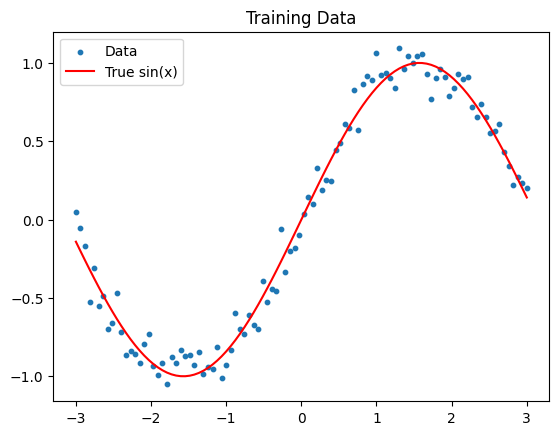

In [2]:
# 100 points between -3 and 3
X = torch.linspace(-3, 3, 100).unsqueeze(1)   # shape: (100, 1)
y = torch.sin(X) + 0.1 * torch.randn_like(X)  # shape: (100, 1)

plt.scatter(X.numpy(), y.numpy(), s=10, label='Data')
plt.plot(X.numpy(), torch.sin(X).numpy(), 'r', label='True sin(x)')
plt.legend()
plt.title('Training Data')
plt.show()

## 2. Initialize Weights & Biases

Each layer needs a **weight matrix W** and a **bias vector b**.

- `W1`: connects input(1) → hidden1(16)  → shape (1, 16)
- `W2`: connects hidden1(16) → hidden2(16) → shape (16, 16)
- `W3`: connects hidden2(16) → output(1)  → shape (16, 1)

We set `requires_grad=True` so PyTorch tracks gradients through them.

In [3]:
# --- Layer sizes ---
n_in, n_h1, n_h2, n_out = 1, 16, 16, 1

# --- He initialization (good default for ReLU) ---
# scale = sqrt(2 / fan_in)
W1 = torch.randn(n_in, n_h1) * (2 / n_in) ** 0.5;  W1.requires_grad_(True)
b1 = torch.zeros(n_h1,       requires_grad=True)

W2 = torch.randn(n_h1, n_h2) * (2 / n_h1) ** 0.5; W2.requires_grad_(True)
b2 = torch.zeros(n_h2,       requires_grad=True)

W3 = torch.randn(n_h2, n_out) * (2 / n_h2) ** 0.5; W3.requires_grad_(True)
b3 = torch.zeros(n_out,       requires_grad=True)

# Collect all parameters in one list — handy for the update step
params = [W1, b1, W2, b2, W3, b3]

print('W1 shape:', W1.shape)
print('W2 shape:', W2.shape)
print('W3 shape:', W3.shape)

W1 shape: torch.Size([1, 16])
W2 shape: torch.Size([16, 16])
W3 shape: torch.Size([16, 1])


## 3. Define Forward Pass

The forward pass computes predictions from inputs.

For each layer:  
1. **Linear transform**: `z = X @ W + b`  
2. **Activation**: `a = ReLU(z)` (except the final output layer)

ReLU simply sets all negative values to zero: `max(0, z)`

In [4]:
def relu(z):
    """ReLU activation: keep positives, zero out negatives."""
    return z.clamp(min=0)   # equivalent to torch.max(z, torch.zeros_like(z))

def forward(X):
    """Full forward pass through the 3-layer network."""
    # --- Layer 1 ---
    z1 = X @ W1 + b1        # (N,1)@(1,16) + (16,) = (N,16)
    a1 = relu(z1)           # (N,16)

    # --- Layer 2 ---
    z2 = a1 @ W2 + b2       # (N,16)@(16,16) + (16,) = (N,16)
    a2 = relu(z2)           # (N,16)

    # --- Output layer (no activation for regression) ---
    z3 = a2 @ W3 + b3       # (N,16)@(16,1) + (1,) = (N,1)

    return z3

# Quick shape check
y_pred_test = forward(X)
print('Output shape:', y_pred_test.shape)  # should be (100, 1)

Output shape: torch.Size([100, 1])


## 4. Define Loss Function

**Mean Squared Error (MSE):**  
`loss = mean( (y_pred - y_true)^2 )`

We compute this by hand — no `torch.nn.MSELoss`.

In [5]:
def mse_loss(y_pred, y_true):
    """Mean Squared Error loss."""
    return ((y_pred - y_true) ** 2).mean()

## 5. Training Loop

Each training step:
1. **Forward pass** — compute predictions
2. **Compute loss** — how wrong are we?
3. **Zero gradients** — clear old gradients (they accumulate otherwise)
4. **Backward pass** — PyTorch computes ∂loss/∂(every param)
5. **Gradient descent update** — `param = param - lr * grad`  
   We use `torch.no_grad()` here so this step is not tracked.

In [6]:
learning_rate = 0.01
n_epochs = 2000
loss_history = []

for epoch in range(n_epochs):

    # ----- Step 1: Forward pass -----
    y_pred = forward(X)

    # ----- Step 2: Compute loss -----
    loss = mse_loss(y_pred, y)

    # ----- Step 3: Zero out old gradients -----
    for p in params:
        if p.grad is not None:
            p.grad.zero_()

    # ----- Step 4: Backward pass (autograd fills .grad on each param) -----
    loss.backward()

    # ----- Step 5: Manually update each parameter -----
    with torch.no_grad():           # don't track this arithmetic
        for p in params:
            p -= learning_rate * p.grad

    loss_history.append(loss.item())

    if (epoch + 1) % 200 == 0:
        print(f'Epoch {epoch+1:4d} | Loss: {loss.item():.6f}')

Epoch  200 | Loss: 0.108480
Epoch  400 | Loss: 0.068186
Epoch  600 | Loss: 0.044322
Epoch  800 | Loss: 0.031746
Epoch 1000 | Loss: 0.025330
Epoch 1200 | Loss: 0.021488
Epoch 1400 | Loss: 0.018771
Epoch 1600 | Loss: 0.017140
Epoch 1800 | Loss: 0.016057
Epoch 2000 | Loss: 0.015192


## 6. Plot Training Loss

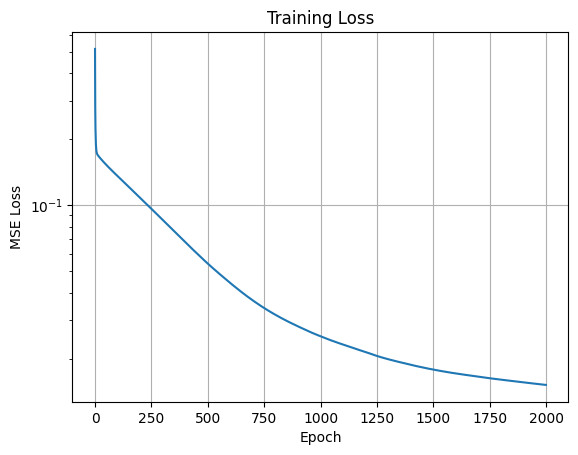

In [7]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.yscale('log')   # log scale makes the curve easier to read
plt.grid(True)
plt.show()

## 7. Visualize Predictions vs True Function

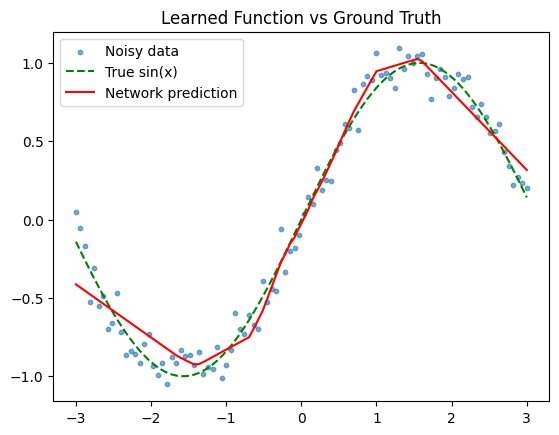

In [8]:
with torch.no_grad():
    y_pred_final = forward(X)

plt.scatter(X.numpy(), y.numpy(), s=10, label='Noisy data', alpha=0.6)
plt.plot(X.numpy(), torch.sin(X).numpy(), 'g--', label='True sin(x)')
plt.plot(X.numpy(), y_pred_final.numpy(), 'r',   label='Network prediction')
plt.legend()
plt.title('Learned Function vs Ground Truth')
plt.show()

## 8. Inspect Learned Weights

Just to make it concrete — these are the actual numbers the network learned.

In [9]:
with torch.no_grad():
    print('W1 (first 4 cols):\n', W1[:, :4])
    print('\nb1 (first 4):', b1[:4])
    print('\nW3 (output weights):\n', W3)
    print('\nb3 (output bias):', b3)

W1 (first 4 cols):
 tensor([[ 1.0308,  0.1180, -0.5851,  0.7074]], requires_grad=True)

b1 (first 4): tensor([-0.0718,  0.1936, -0.1364,  0.4885], requires_grad=True)

W3 (output weights):
 tensor([[ 0.6824],
        [-0.5247],
        [-0.2125],
        [-0.0050],
        [-0.4418],
        [ 0.4143],
        [-0.8252],
        [-0.2461],
        [ 0.4439],
        [-0.1650],
        [-0.4282],
        [ 0.4453],
        [ 0.7099],
        [-0.4982],
        [-0.0975],
        [ 0.0492]], requires_grad=True)

b3 (output bias): tensor([-0.2441], requires_grad=True)


## Summary — What happened under the hood?

| Step | What we did manually |
|------|----------------------|
| Weights | Created tensors with `requires_grad=True` |
| Forward | Matrix multiply `X @ W + b`, then ReLU |
| Loss | `mean((pred - true)^2)` |
| Backward | Called `loss.backward()` — PyTorch fills `.grad` |
| Update | `param -= lr * param.grad` inside `torch.no_grad()` |

PyTorch's `nn.Linear` and `optim.SGD` do exactly this — they just wrap it up neatly.
Now you know what's inside!